<a href="https://colab.research.google.com/github/morgan03153/game/blob/master/morgan_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance pandas numpy scikit-learn keras google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client google-cloud-storage


畫曲線圖

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_datareader.data as web

# 設定時間範圍
end_date = datetime.today()
start_date = end_date - timedelta(days=60)

# 獲取1個月期美國國債殖利率
treasury_1mo = web.DataReader('DGS1MO', 'fred', start_date, end_date)

# 獲取其他數據
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 合併數據以便於繪圖
combined_data = pd.DataFrame({
    '1-Month Treasury Yield': treasury_1mo['DGS1MO'],
    'VIX': vix_data['Close'],
    'VOO': voo_data['Close'],
    'NVDA': nvda_data['Close'],
    'MSFT': msft_data['Close'],
    'AVGO': avgo_data['Close']
})

# 正規化處理，使每條曲線的第一點為100
normalized_data = combined_data.apply(lambda x: (x / x.iloc[0]) * 100)

# 定義不同的marker
markers = ['o', 'x', 's', 'D', '^', 'v']

# 繪製所有曲線在同一張圖上，並在每一點加上不同的標記
plt.figure(figsize=(14, 8))

for i, column in enumerate(normalized_data.columns):
    plt.plot(normalized_data.index, normalized_data[column], label=column, marker=markers[i])

plt.title('Normalized 1-Month Treasury Yield, VIX, and Selected Stocks (Base 100)')
plt.xlabel('Date')
plt.ylabel('Normalized Value (Base 100)')
plt.legend(loc='upper left')
plt.grid(True)

# 调整X轴日期标签为直式显示
plt.xticks(rotation=90)

plt.show()


**使用LSTM訓練去預估NVDA在接下來14天內是否曾累積跌10%**
1. 引入必要的庫
yfinance 用於從 Yahoo Finance 下載股票數據。
pandas 用於數據處理。
datetime 和 timedelta 用於處理日期。
MinMaxScaler 用於標準化數據。
Sequential, Dense, LSTM, Dropout 是 Keras 中用於構建神經網絡模型的層。
save_model 和 joblib 用於保存模型和標準化器。
drive 用於連接 Google Drive，以保存模型。
pandas_datareader 用於從金融數據源獲取數據。
2. 連接Google Drive
使用 drive.mount('/content/drive') 將 Google Drive 掛載到工作目錄中，以便後續將模型和標準化器保存到指定位置。
3. 設置保存模型和標準化器的路徑
指定將訓練好的模型和標準化器保存到 Google Drive 中的 nvda_lstm 目錄。
4. 設定時間範圍
使用 datetime 和 timedelta 設定股票數據的時間範圍，從當前日期開始往前60天。
5. 下載股票和指數數據
使用 yfinance 下載英伟达（NVDA）、波动率指数（VIX）、Vanguard S&P 500 ETF（VOO）、微軟（MSFT）、博通（AVGO）等股票和指數的數據。
如果需要，也可以獲取美國1個月期國債殖利率數據（這部分代碼被註釋掉了）。
6. 填充缺失值
使用 ffill 和 bfill 方法填充缺失數據，以確保數據連續性。ffill 是向前填充，bfill 是向後填充。
7. 對齊所有數據的索引
將所有股票和指數的收盤價數據合併到一個 DataFrame 中，並去除任何包含缺失值的行。
將合併後的數據標籤設置為股票代號（如 NVDA、VIX、VOO 等）。
8. 將 NVDA 的數據與特徵數據對齊
將英伟达（NVDA）的數據與合併的特徵數據對齊，以確保後續處理中時間軸一致。
9. 標準化數據
為了讓數據進入神經網絡模型進行有效訓練，將股票和指數的收盤價標準化到0到1之間的範圍。
MinMaxScaler 用於將數據進行標準化，以避免不同數據列之間的量級差異影響模型的訓練。
10. 處理 NVDA 的收盤價
將 NVDA 的收盤價單獨取出，並使用 MinMaxScaler 進行標準化，為後續模型訓練做準備。
目的：
這段代碼的主要目的是準備數據，以便使用LSTM模型進行股票價格預測。LSTM模型在處理時間序列數據時非常有效，因此這裡使用了LSTM模型來預測英伟达（NVDA）的未來股票價格。標準化數據和對齊時間序列是準備LSTM模型訓練的重要步驟。後續步驟可能會包括構建和訓練LSTM模型，以及將訓練好的模型保存下來，以便將來進行預測。


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import save_model
import joblib
from google.colab import drive
import pandas_datareader.data as web

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型和標準化器的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 确保保存路径存在
import os
os.makedirs(save_path, exist_ok=True)

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=60)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 獲取美國1個月期國債殖利率數據
# treasury_1mo = web.DataReader('DGS1MO', 'fred', start_date, end_date)


# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')
# treasury_1mo = treasury_1mo.fillna(method='ffill').fillna(method='bfill')

#breakpoint()
# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close'], avgo_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT', 'AVGO']

# 将 NVDA 数据与特征数据对齐
nvda_data_aligned = nvda_data.loc[combined_data.index]

# 标准化数据
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[column].values.reshape(-1, 1))
    scalers[column] = scaler

nvda_close = nvda_data_aligned['Close'].values.reshape(-1, 1)
nvda_scaler = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = nvda_scaler.fit_transform(nvda_close)

# 創建數據集，y 值使用 NVDA 的股價，判断未来14天内是否曾經下跌超过10%
def create_dataset(X, y, look_back=60, forward_days=14):
    Xs, ys = [], []
    data_length = len(X) - look_back - forward_days
    print(f"data_length={data_length}")
    for i in range(len(X) - look_back - forward_days):
        Xs.append(X[i:i + look_back])
        # 判断未来14天内是否曾經计下跌超过10%的情况
        future_window = y[i + look_back : i + look_back + forward_days]
        max_drop = np.max((y[i + look_back] - future_window) / y[i + look_back])
        ys.append(1 if max_drop >= 0.1 else 0)
    return np.array(Xs), np.array(ys)

look_back = 60
forward_days = 14
print(f"comfined_data valuess:{combined_data.values} ")
X, y_binary = create_dataset(combined_data.values, nvda_scaled, look_back, forward_days)
breakpoint()
# 构建LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 拆分数据集为训练集和测试集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y_binary[:split], y_binary[split:]

# 训练模型
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# 保存模型和標準化器
model_path = os.path.join(save_path, 'nvda_lstm_model_14days.h5')
scaler_paths = {k: os.path.join(save_path, f"{k}_scaler.pkl") for k in scalers}

save_model(model, model_path)

# 保存 scalers
joblib.dump(nvda_scaler, os.path.join(save_path, 'nvda_scaler.pkl'))
for k, scaler in scalers.items():
    joblib.dump(scaler, scaler_paths[k])

print(f"模型已保存到 {model_path}")
for k, path in scaler_paths.items():
    print(f"{k} 的 scaler 已保存到 {path}")


預測程式

In [ ]:
from keras.models import load_model
import numpy as np
import pandas as pd
import joblib
from datetime import datetime, timedelta
import yfinance as yf
import pandas_datareader.data as web
from google.colab import drive

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型和標準化器的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 加载模型和scalers
model_path = os.path.join(save_path, 'nvda_lstm_model_14days.h5')
nvda_scaler = joblib.load(os.path.join(save_path, 'nvda_scaler.pkl'))
scaler_paths = {
    "1-Month Treasury Yield": os.path.join(save_path, '1-Month Treasury Yield_scaler.pkl'),
    "VIX": os.path.join(save_path, 'VIX_scaler.pkl'),
    "VOO": os.path.join(save_path, 'VOO_scaler.pkl'),
    "MSFT": os.path.join(save_path, 'MSFT_scaler.pkl'),
    "AVGO": os.path.join(save_path, 'AVGO_scaler.pkl')
}

model = load_model(model_path)
scalers = {k: joblib.load(path) for k, path in scaler_paths.items()}

# 設定時間範圍
end_date = datetime.today() - timedelta(days=25)
start_date = end_date - timedelta(days=600)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 獲取美國1個月期國債殖利率數據
treasury_1mo = web.DataReader('DGS1MO', 'fred', start_date, end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')
treasury_1mo = treasury_1mo.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([treasury_1mo, vix_data['Close'], voo_data['Close'], msft_data['Close'], avgo_data['Close']], axis=1).dropna()
combined_data.columns = ['1-Month Treasury Yield', 'VIX', 'VOO', 'MSFT', 'AVGO']

# 将 NVDA 数据与特征数据对齐
nvda_data_aligned = nvda_data.loc[combined_data.index]

# 标准化数据
for column in combined_data.columns:
    combined_data[column] = scalers[column].transform(combined_data[column].values.reshape(-1, 1))

nvda_close = nvda_data_aligned['Close'].values.reshape(-1, 1)
nvda_scaled = nvda_scaler.transform(nvda_close)

# 获取最近60天的数据
look_back = 60
last_lookback = np.array([combined_data.values[-look_back:]])

# 预测未来14天内NVDA股价是否累计下跌超过10%
predicted_value = model.predict(last_lookback)

if predicted_value > 0.5:
    print("预测未来14天内NVDA股价有超过10%的累计下跌风险。")
else:
    print("预测未来14天内NVDA股价没有超过10%的累计下跌风险。")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-21-eb3757843422>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-eb3757843422>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-eb3757843422>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-21-eb3757843422>:40: FutureWarning: DataFrame.fillna wi

JSON file saved to: /content/drive/My Drive/nvda_lstm/nvda_y_binary.json


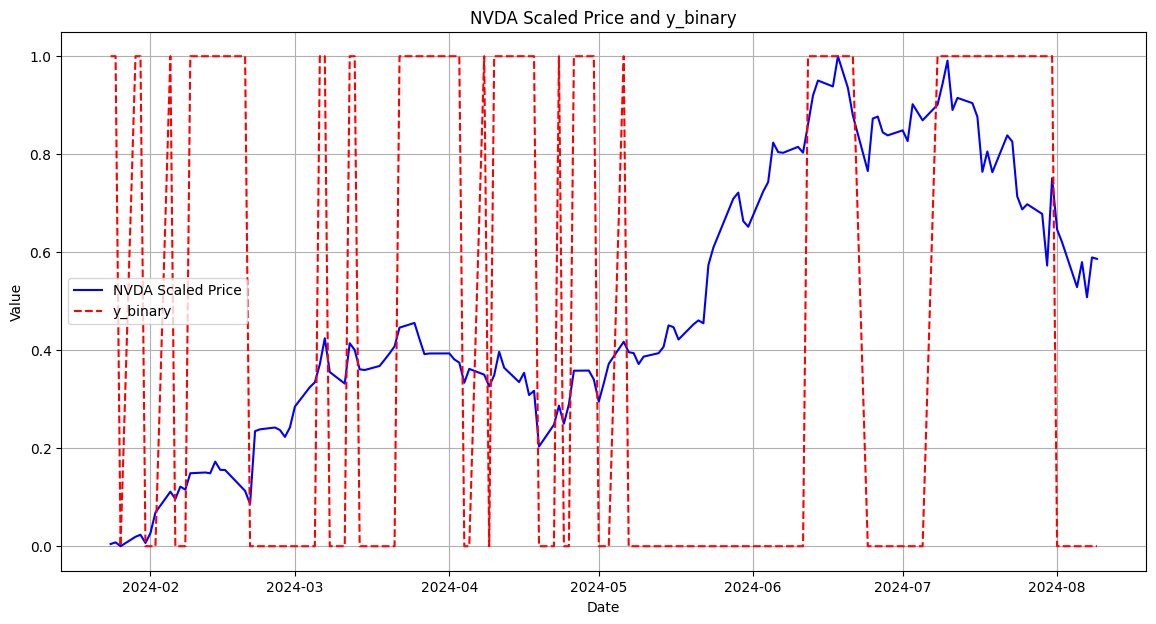

In [21]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from google.colab import drive

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型和標準化器的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 确保保存路径存在
os.makedirs(save_path, exist_ok=True)

# 可調整的變數
days_range = 200        # 設定時間範圍天數
forward_days = 7      # 設定未來天數範圍
drop_threshold = 0.9   # 設定價格下跌比例的閾值

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=days_range)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close'], avgo_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT', 'AVGO']

# 将 NVDA 数据与特征数据对齐
nvda_data_aligned = nvda_data.loc[combined_data.index]

# 标准化数据
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[column].values.reshape(-1, 1))
    scalers[column] = scaler

nvda_close = nvda_data_aligned['Close'].values.reshape(-1, 1)
nvda_scaler = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = nvda_scaler.fit_transform(nvda_close)

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = nvda_scaled[i + 1 : i + 1 + forward_days]
        if np.any(future_prices < current_price * drop_threshold):
            y_binary[i] = 1
    return y_binary

y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

# 將 y_binary 和 nvda_scaled 對齊後保存為 JSON 文件
aligned_data = {
    "date": nvda_data_aligned.index.strftime('%Y-%m-%d').tolist(),
    "nvda_scaled": nvda_scaled.flatten().tolist(),
    "y_binary": y_binary.flatten().tolist()
}

json_file_path = os.path.join(save_path, 'nvda_y_binary.json')
with open(json_file_path, 'w') as f:
    json.dump(aligned_data, f)

print(f'JSON file saved to: {json_file_path}')

# 畫出圖表，將 nvda_scaled 和 y_binary 放在同一張圖中
plt.figure(figsize=(14, 7))
plt.plot(nvda_data_aligned.index, nvda_scaled, label='NVDA Scaled Price', color='blue')
plt.plot(nvda_data_aligned.index, y_binary, label='y_binary', color='red', linestyle='dashed')
plt.title('NVDA Scaled Price and y_binary')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
訓練程式

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from google.colab import drive
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
import joblib

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型和標準化器的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
days_range = 300        # 設定時間範圍天數
forward_days = 7      # 設定未來天數範圍
drop_threshold = 0.9   # 設定價格下跌比例的閾值
look_back = 200         # LSTM 模型的 look back 時間窗口

# 設定時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=days_range)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close'], avgo_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT', 'AVGO']

# 标准化数据
scalers = {}
for column in combined_data.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    combined_data[column] = scaler.fit_transform(combined_data[column].values.reshape(-1, 1))
    scalers[column] = scaler

nvda_close = nvda_data['Close'].values.reshape(-1, 1)
nvda_scaler = MinMaxScaler(feature_range=(0, 1))
nvda_scaled = nvda_scaler.fit_transform(nvda_close)

# 創建 y_binary 值，判断未來指定天數內是否曾經跌破當日股價的指定比例
def create_y_binary(nvda_scaled, forward_days, drop_threshold):
    y_binary = np.zeros_like(nvda_scaled)
    for i in range(len(nvda_scaled) - forward_days):
        current_price = nvda_scaled[i]
        future_prices = nvda_scaled[i + 1 : i + 1 + forward_days]
        if np.any(future_prices < current_price * drop_threshold):
            y_binary[i] = 1
    return y_binary

y_binary = create_y_binary(nvda_scaled, forward_days, drop_threshold)

# 創建數據集
def create_dataset(X, y, look_back):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        Xs.append(X[i:i + look_back])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

# 創建 X 和 y 數據集
X, y = create_dataset(combined_data.values, y_binary, look_back)

# 確認 X 的形狀
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 確保 X 是三維的
if len(X.shape) != 3:
    raise ValueError("X does not have the correct shape. Expected a 3D array.")

# 拆分訓練集和測試集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 構建 LSTM 模型
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 訓練模型
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# 保存模型
model_save_path = os.path.join(save_path, 'nvda_lstm_model.h5')
model.save(model_save_path)
print(f'Model saved to: {model_save_path}')

# 保存標準化器
scaler_save_path = os.path.join(save_path, 'nvda_scaler.gz')
joblib.dump(scalers, scaler_save_path)
print(f'Scalers saved to: {scaler_save_path}')


預測程式

In [30]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from google.colab import drive
from keras.models import load_model
import joblib
from IPython.display import display, HTML

# 连接Google Drive
drive.mount('/content/drive')

# 設定保存模型和標準化器的路徑
save_path = '/content/drive/My Drive/nvda_lstm/'

# 可調整的變數
data_days = 300        # 用于提取数据的天数
look_back = 200        # LSTM 模型的 look back 时间窗口
forward_days = 7       # 設定未来天数范围
drop_threshold = 0.9   # 設定价格下跌比例的閾值

# 載入模型和標準化器
model_path = os.path.join(save_path, 'nvda_lstm_model.h5')
scaler_path = os.path.join(save_path, 'nvda_scaler.gz')

model = load_model(model_path)
scalers = joblib.load(scaler_path)

# 設定預測時間範圍
end_date = datetime.today() - timedelta(days=0)
start_date = end_date - timedelta(days=data_days)

# 獲取各個股票和指數的數據
nvda_data = yf.download('NVDA', start=start_date, end=end_date)
vix_data = yf.download('^VIX', start=start_date, end=end_date)
voo_data = yf.download('VOO', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)
avgo_data = yf.download('AVGO', start=start_date, end=end_date)

# 填充缺失值
nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
voo_data = voo_data.fillna(method='ffill').fillna(method='bfill')
msft_data = msft_data.fillna(method='ffill').fillna(method='bfill')
avgo_data = avgo_data.fillna(method='ffill').fillna(method='bfill')

# 对齐所有数据的索引
combined_data = pd.concat([nvda_data['Close'], vix_data['Close'], voo_data['Close'], msft_data['Close'], avgo_data['Close']], axis=1).dropna()
combined_data.columns = ['NVDA', 'VIX', 'VOO', 'MSFT', 'AVGO']

# 对最新数据进行标准化
for column in combined_data.columns:
    combined_data[column] = scalers[column].transform(combined_data[column].values.reshape(-1, 1))

# 确保数据大小足够进行预测
if len(combined_data) >= look_back:
    # 准备输入数据给模型进行预测
    X_input = combined_data.values[-look_back:].reshape(1, look_back, combined_data.shape[1])

    # 模型预测
    y_pred = model.predict(X_input)
    predicted_label = (y_pred > 0.5).astype(int)[0][0]

    # 获取当前日期
    prediction_date = nvda_data.index[-1].strftime('%Y-%m-%d')

    # 显示预测结果
    if predicted_label == 1:
        display(HTML(f'<p style="color: red; font-weight: bold; animation: blinker 1s linear infinite;">{prediction_date}: 是</p>'))
    else:
        print(f"{prediction_date}: 否")

    # 保存预测结果到JSON文件
    prediction_data = {
        "date": prediction_date,
        "predicted_label": int(predicted_label)
    }

    json_prediction_path = os.path.join(save_path, 'nvda_daily_prediction.json')
    with open(json_prediction_path, 'w') as f:
        json.dump(prediction_data, f)

    print(f'Prediction saved to: {json_prediction_path}')

    # 添加闪烁效果的CSS
    display(HTML("""
    <style>
    @keyframes blinker {
      50% { opacity: 0; }
    }
    </style>
    """))
else:
    print("数据不足，无法进行预测，请稍后再试。")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<ipython-input-30-9dd94d6193d7>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nvda_data = nvda_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-30-9dd94d6193d7>:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vix_data = vix_data.fillna(method='ffill').fillna(method='bfill')
<ipython-input-30-9dd94d6193d7>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
2024-08-09: 否
Prediction saved to: /content/drive/My Drive/nvda_lstm/nvda_daily_prediction.json
